In [1]:
import torch

from torch.utils.data import DataLoader, random_split
from torchvision import transforms

In [2]:
BATCH_SIZE = 32
LEARNING_RATE = 0.001
EPOCHS = 32

In [3]:
from dataset import DataSet

dataset = DataSet(
    directory="./images",
    transform=transforms.Compose(
        [
            transforms.Resize((128, 128)),
            # transforms.RandomHorizontalFlip(),
            # transforms.RandomVerticalFlip(),
            # transforms.RandomRotation(30),
        ]
    ),
)

train_size = int(0.75 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [4]:
from unet3plus import LateFusionUNet
from loss import DiceLoss, IoULoss

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LateFusionUNet(1, 1).to(device)

dice_criterion = DiceLoss()
iou_criterion = IoULoss()

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [5]:
training_loss = []
testing_loss = []
training_dice_scores = []
training_iou_scores = []
testing_dice_scores = []
testing_iou_scores = []

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0.0
    total_dice = 0.0
    total_iou = 0.0

    for i, (echogenicity, elasticity, mask) in enumerate(train_loader):
        echogenicity, elasticity, mask = (
            echogenicity.to(device),
            elasticity.to(device),
            mask.to(device),
        )

        optimizer.zero_grad()

        output = model(echogenicity, elasticity)
        dice_loss = dice_criterion(output, mask)
        iou_loss = iou_criterion(output, mask)
        loss = 0.5 * dice_loss + 0.5 * iou_loss
        loss.backward()

        optimizer.step()

        total_loss += loss.item()
        total_dice += 1 - dice_loss.item()
        total_iou += 1 - iou_loss.item()

    training_loss.append(total_loss / len(train_loader))
    training_dice_scores.append(total_dice / len(train_loader))
    training_iou_scores.append(total_iou / len(train_loader))

    model.eval()
    total_loss = 0.0
    total_dice = 0.0
    total_iou = 0.0

    with torch.no_grad():
        for i, (echogenicity, elasticity, mask) in enumerate(test_loader):
            echogenicity, elasticity, mask = (
                echogenicity.to(device),
                elasticity.to(device),
                mask.to(device),
            )

            output = model(echogenicity, elasticity)
            dice_loss = dice_criterion(output, mask)
            iou_loss = iou_criterion(output, mask)
            loss = 0.5 * dice_loss + 0.5 * iou_loss

            total_loss += loss.item()
            total_dice += 1 - dice_loss.item()
            total_iou += 1 - iou_loss.item()

    testing_loss.append(total_loss / len(test_loader))
    testing_dice_scores.append(total_dice / len(test_loader))
    testing_iou_scores.append(total_iou / len(test_loader))

    print(
        f"Epoch [{epoch+1}/{EPOCHS}], "
        f"Training Loss: {training_loss[-1]:.4f}, "
        f"Testing Loss: {testing_loss[-1]:.4f}, "
        f"Training Dice: {training_dice_scores[-1]:.4f}, "
        f"Testing Dice: {testing_dice_scores[-1]:.4f}, "
        f"Training IoU: {training_iou_scores[-1]:.4f}, "
        f"Testing IoU: {testing_iou_scores[-1]:.4f}"
    )

    if epoch == 0 or testing_loss[-1] < min(testing_loss[:-1]):
        torch.save(model.state_dict(), "models/model_" + str(epoch) + ".pth")


Epoch [1/32], Training Loss: 0.8921, Testing Loss: 0.9538, Training Dice: 0.1396, Testing Dice: 0.0609, Training IoU: 0.0761, Testing IoU: 0.0314
Epoch [2/32], Training Loss: 0.6579, Testing Loss: 0.9557, Training Dice: 0.4159, Testing Dice: 0.0585, Training IoU: 0.2682, Testing IoU: 0.0301
Epoch [3/32], Training Loss: 0.4145, Testing Loss: 0.8458, Training Dice: 0.6679, Testing Dice: 0.1981, Training IoU: 0.5030, Testing IoU: 0.1102
Epoch [4/32], Training Loss: 0.3261, Testing Loss: 0.9902, Training Dice: 0.7486, Testing Dice: 0.0131, Training IoU: 0.5992, Testing IoU: 0.0066
Epoch [5/32], Training Loss: 0.2935, Testing Loss: 0.9746, Training Dice: 0.7770, Testing Dice: 0.0337, Training IoU: 0.6361, Testing IoU: 0.0172
Epoch [6/32], Training Loss: 0.2884, Testing Loss: 0.5565, Training Dice: 0.7815, Testing Dice: 0.5278, Training IoU: 0.6416, Testing IoU: 0.3592
Epoch [7/32], Training Loss: 0.2637, Testing Loss: 0.3266, Training Dice: 0.8023, Testing Dice: 0.7485, Training IoU: 0.6702

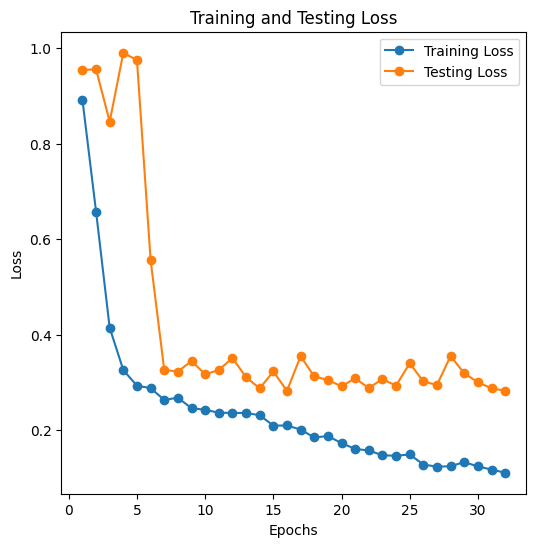

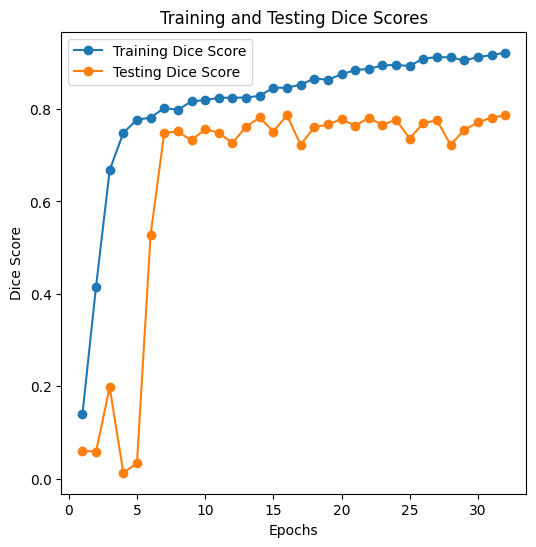

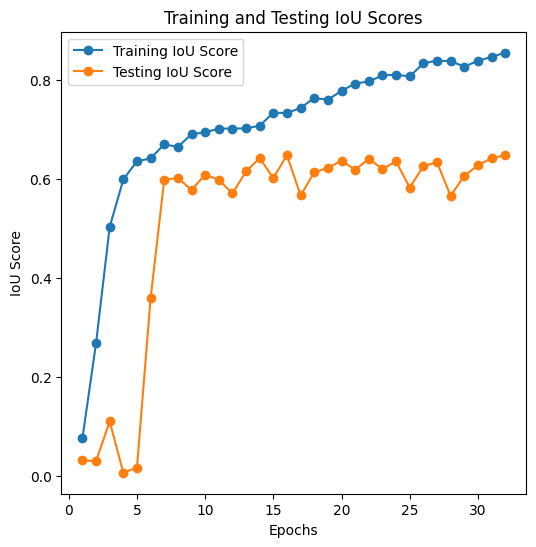

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.plot(range(1, EPOCHS + 1), training_loss, label="Training Loss", marker='o')
plt.plot(range(1, EPOCHS + 1), testing_loss, label="Testing Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Testing Loss")
plt.legend()
plt.show()

plt.figure(figsize=(6, 6))
plt.plot(range(1, EPOCHS + 1), training_dice_scores, label="Training Dice Score", marker='o')
plt.plot(range(1, EPOCHS + 1), testing_dice_scores, label="Testing Dice Score", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Dice Score")
plt.title("Training and Testing Dice Scores")
plt.legend()
plt.show()

plt.figure(figsize=(6, 6))
plt.plot(range(1, EPOCHS + 1), training_iou_scores, label="Training IoU Score", marker='o')
plt.plot(range(1, EPOCHS + 1), testing_iou_scores, label="Testing IoU Score", marker='o')
plt.xlabel("Epochs")
plt.ylabel("IoU Score")
plt.title("Training and Testing IoU Scores")
plt.legend()
plt.show()


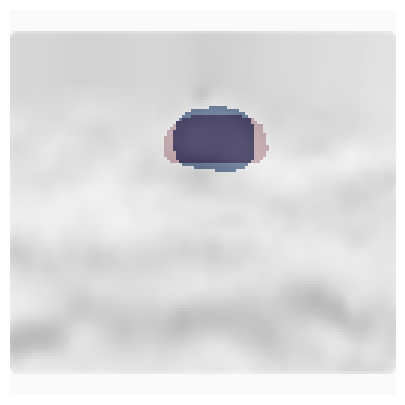

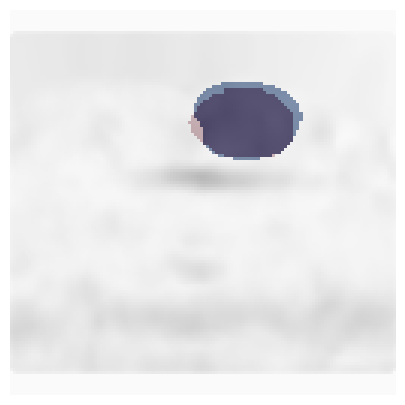

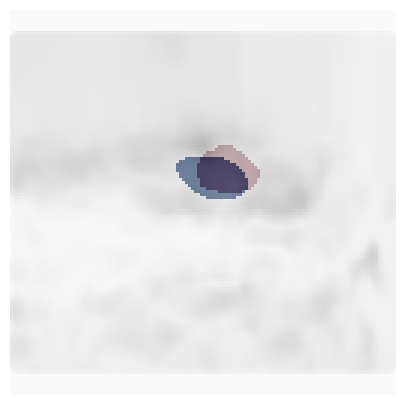

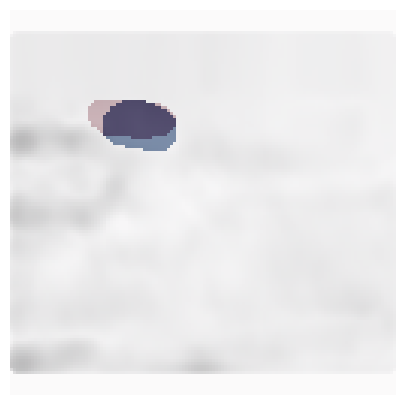

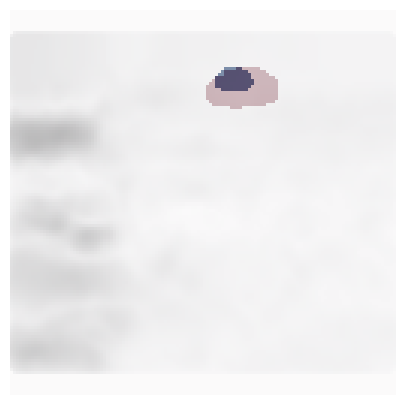

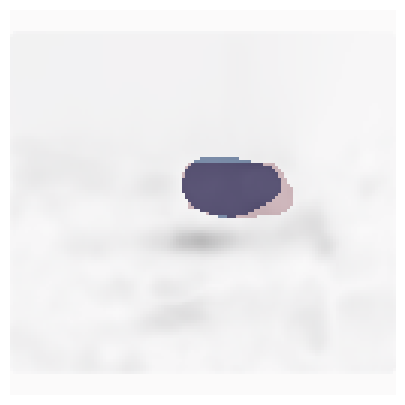

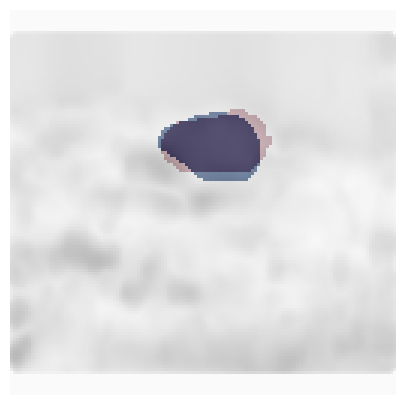

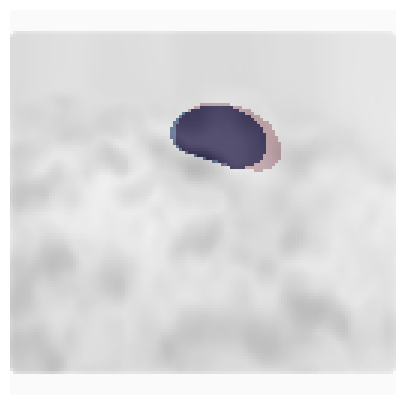

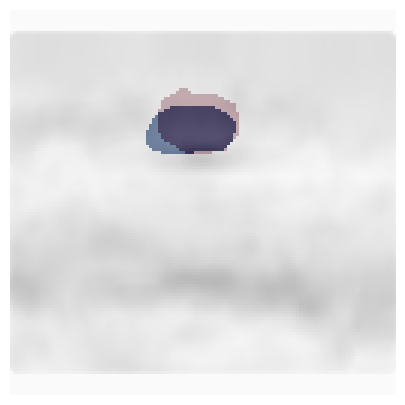

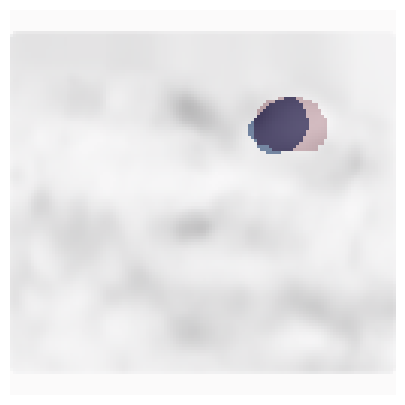

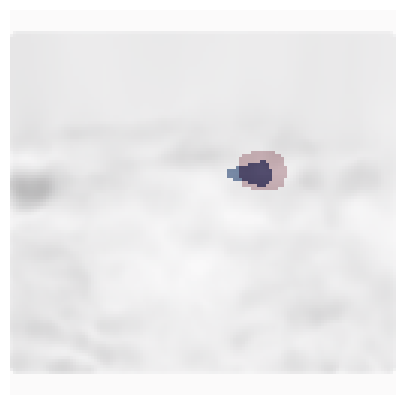

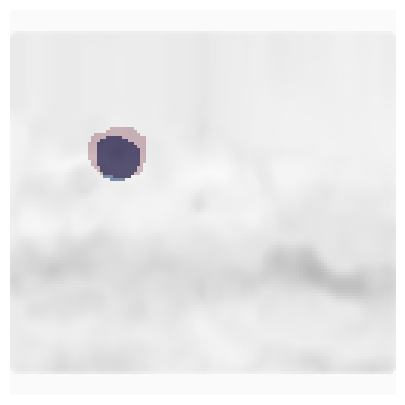

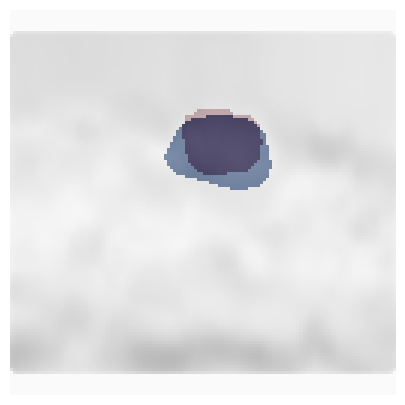

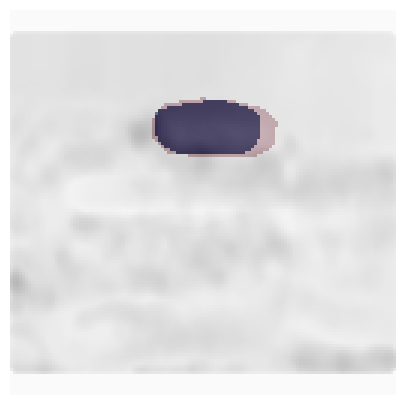

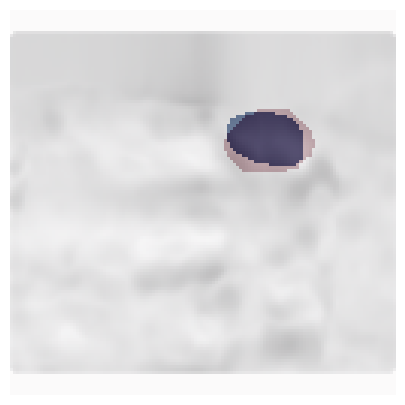

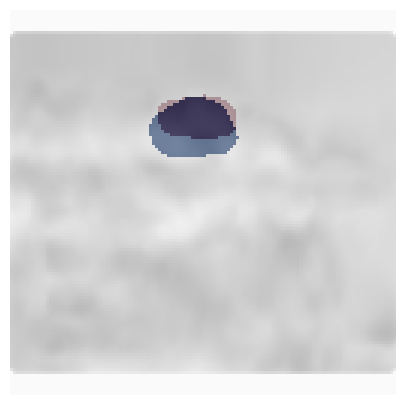

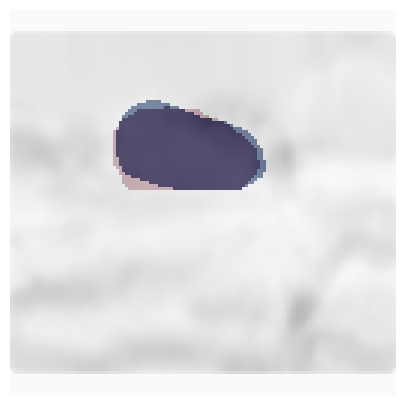

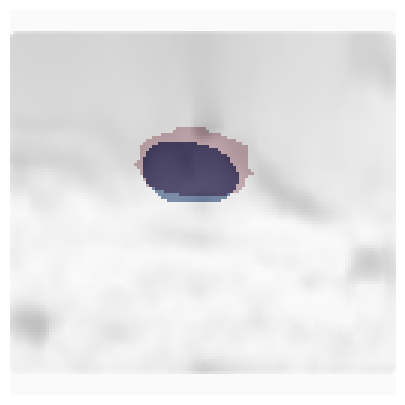

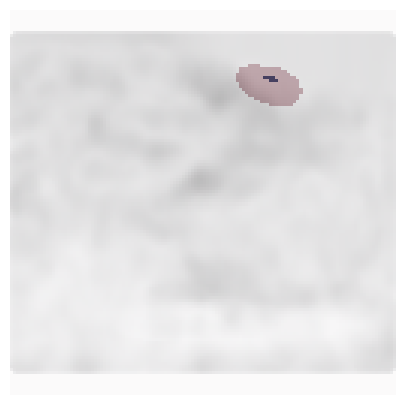

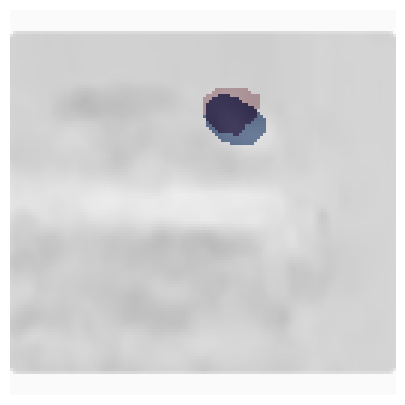

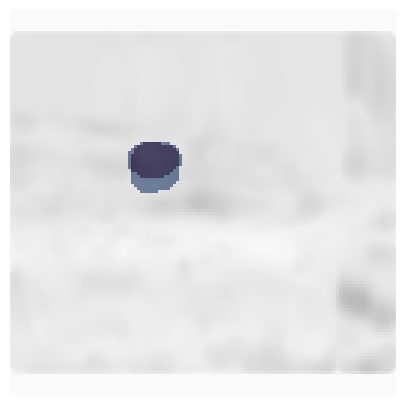

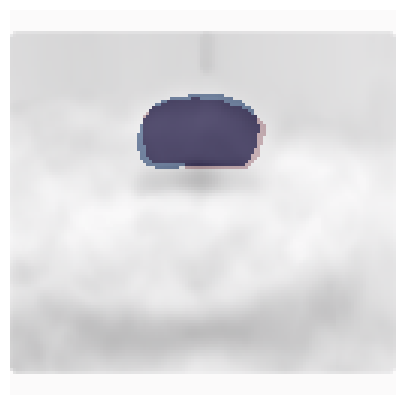

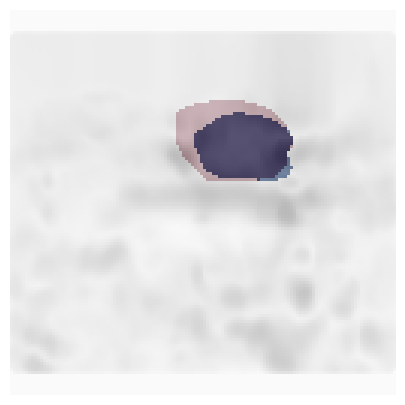

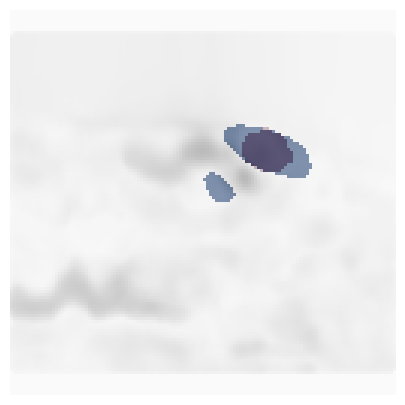

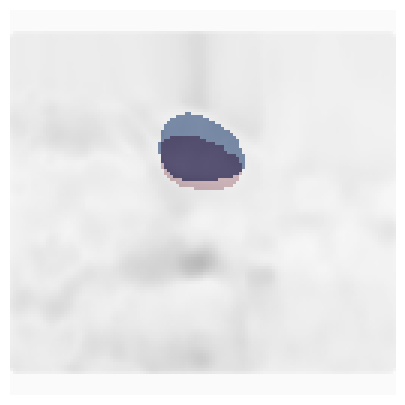

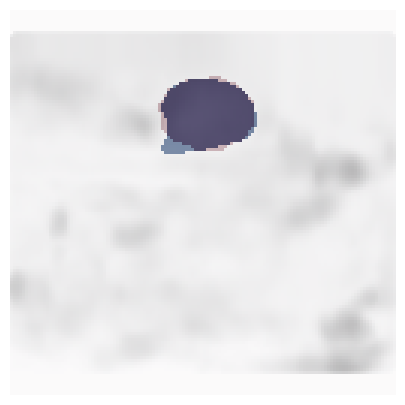

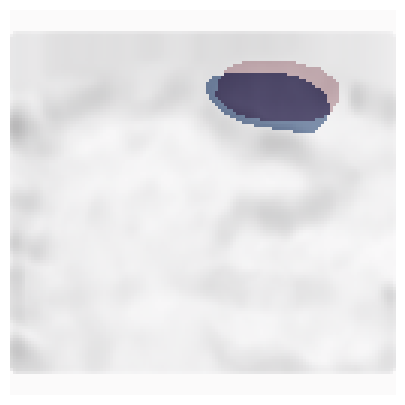

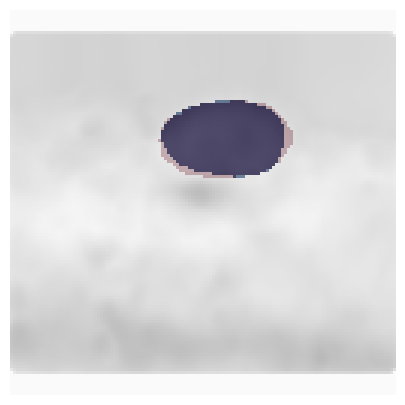

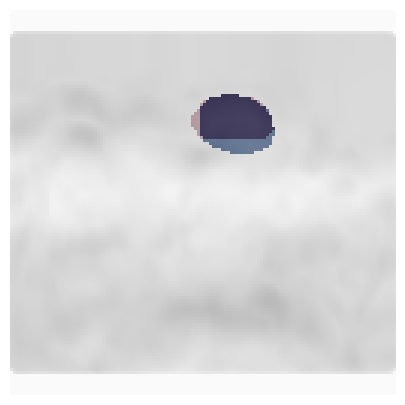

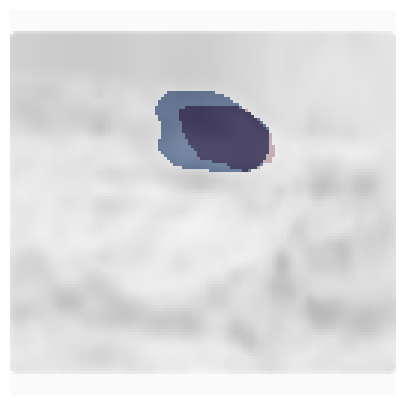

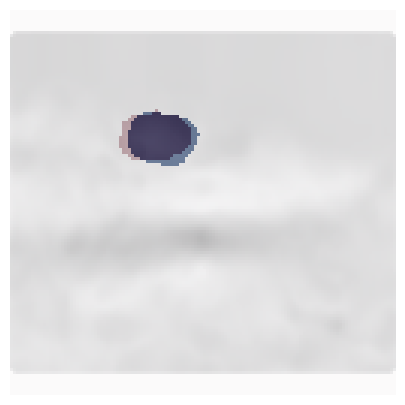

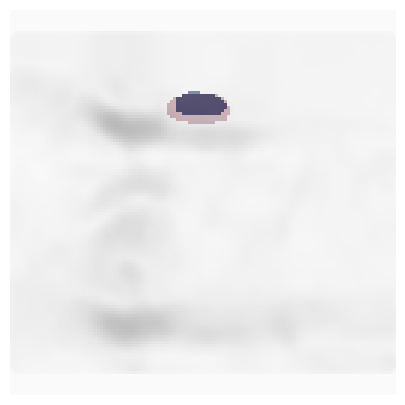

In [7]:
model.eval()

test_batch = next(iter(test_loader))
echogenicity, elasticity, mask = (
    test_batch[0].to(device),
    test_batch[1].to(device),
    test_batch[2].to(device),
)

with torch.no_grad():
    output = model(echogenicity, elasticity)

output = output.cpu().numpy()
mask = mask.cpu().numpy()
elasticity = elasticity.cpu().numpy()

batch_size = elasticity.shape[0]
for i in range(batch_size):
    plt.figure(figsize=(10, 5))

    thresholded_output = (output[i, 0] > 0.5).astype(float)

    plt.imshow(elasticity[i, 0], cmap="gray")
    plt.axis("off")

    plt.imshow(mask[i, 0], cmap="Reds", alpha=0.5)
    plt.imshow(thresholded_output, cmap="Blues", alpha=0.5)

    plt.show()